# Fit Fluorescent Spot from C-Trap Confocal Scan
Script for fitting a symmetric Gaussian to a fluroescent spot in 2D confocal scan data collected on the CTrap.

Take a .h5 file and use lumicks pylake functions to extract the scan data. Crop the image to just the region around the fluorescent spot. Use lmfit to fit the spot and output fit results. Manually do this for each frame you would like to fit.

Working with: -pylake 1.5.2 -lmfit 1.3.2

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import lumicks.pylake as lk
from lmfit import Model

In [12]:
# Choose file name and path from above
file = lk.File("20230726-124740 Scan DNA1_top2a_ATPgS.h5")
scanlist = list(file.scans)  
print(scanlist)

['DNA1_top2a_ATPgS']


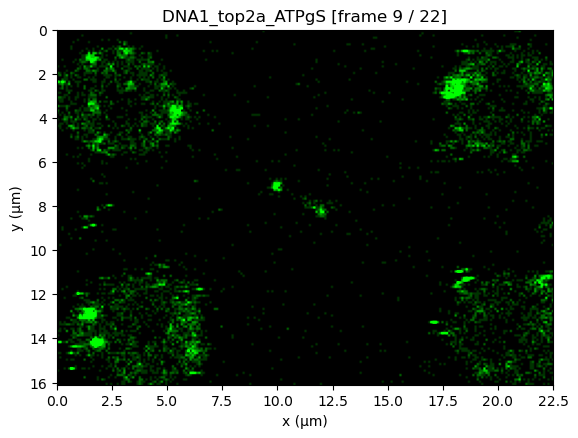

In [13]:
frame_to_fit = 8 #select the frame of the movie where the spot is visable (note starts at 0)
scan = file.scans[scanlist[0]]
scan.plot(channel='green',frame=frame_to_fit, vmax=5) #can change vmax for display depending on brightness of spot

Crop the image to a 20x20 px area which we will use for fitting.
Position the spot approx in the center (as the fitting paratmeter initial guesses expect the spot to be in the center of the cropped image).

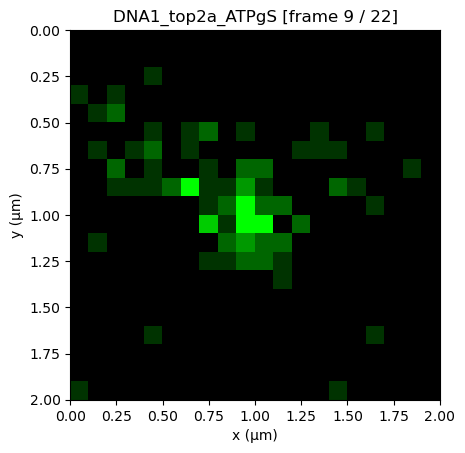

In [14]:
x = 120 #this value is in pixels not um
y = 82 #this value is in pixels not um

x_min=x-10
x_max=x+10
y_min=y-10
y_max=y+10
croppedscan = scan.crop_by_pixels(x_min, x_max, y_min, y_max)
croppedscan.plot(channel='green',frame=frame_to_fit, vmax=5)

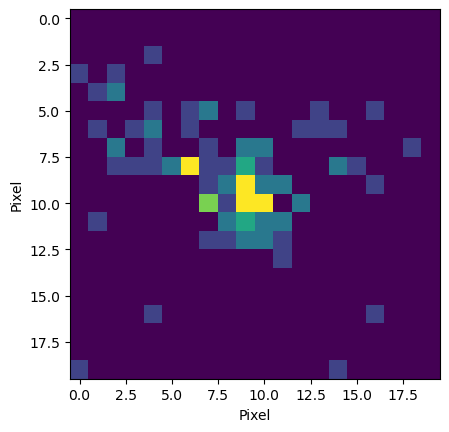

In [15]:
image_data = croppedscan.get_image(channel='green')
plt.imshow(image_data[frame_to_fit], vmax=5)
plt.xlabel("Pixel")
plt.ylabel("Pixel")
plt.show()


Here we define some fitting functions and fucntions for plotting the resutls

In [16]:
# Define a symmetric 2D Gaussian function
def gaussian_2d_symmetric(xy, amplitude, xo, yo, sigma, offset):
    x, y = xy
    xo = float(xo)
    yo = float(yo)
    g = offset + amplitude * np.exp(-((x - xo)**2 + (y - yo)**2) / (2 * sigma**2))
    return g.ravel()

# Fit the data using lmfit
def fit_2d_gaussian_symmetric(xy, data):
    # Flatten the x, y, and data arrays for fitting
    data_flat = data.flatten()
    
    # Create the model
    model = Model(gaussian_2d_symmetric)
    
    # Create initial parameter values and bounds
    params = model.make_params(amplitude=np.max(data) - np.min(data),
                               xo=10, yo=10,
                               sigma=1, offset=np.min(data))
    params['offset'].set(vary=False)
    params['sigma'].set(vary=True)
    
    # Fit the model to the data
    result = model.fit(data_flat, params, xy=xy)
    
    return result

# Plot the results
def plot_results(image, result):
    size = image.shape[0]
    x = np.linspace(0, size-1, size)
    y = np.linspace(0, size-1, size)
    x, y = np.meshgrid(x, y)
    
    # Evaluate the fitted model on the original grid
    data_fitted = result.eval(xy=(x, y)).reshape(image.shape)
    data_residual = image - data_fitted
    
    # Plot the original data and the fitted model
    fig, ax = plt.subplots(1, 3, figsize=(12, 5))
    
    ax[0].imshow(image, cmap='viridis', vmin=0, vmax=4)
    ax[0].set_title('Original Image')
    
    ax[1].imshow(data_fitted, cmap='viridis', vmin=0, vmax=4)
    ax[1].set_title('Fitted Gaussian')

    ax[2].imshow(data_residual, cmap='viridis', vmin=0, vmax=4)
    ax[2].set_title('Residual')
    
    plt.tight_layout()
    plt.show()
    
    # Print fit report
    print(result.fit_report())

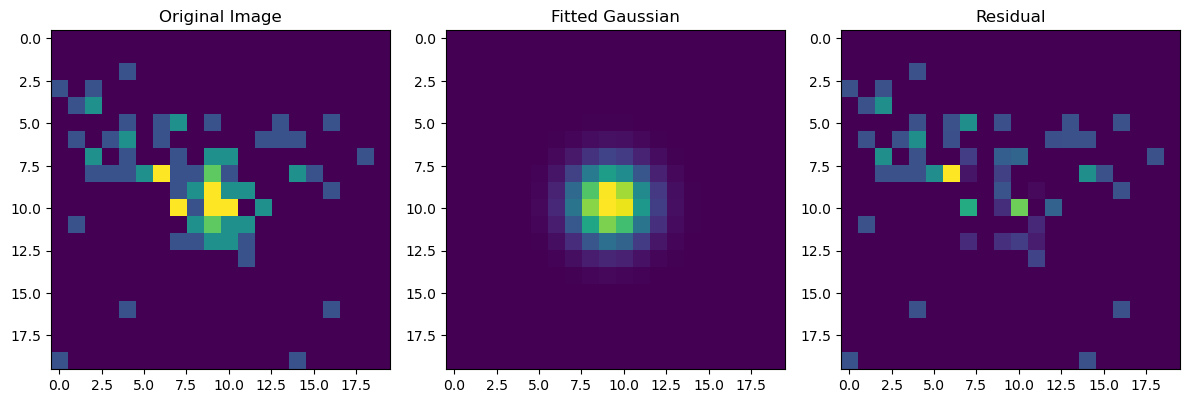

[[Model]]
    Model(gaussian_2d_symmetric)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 66
    # data points      = 400
    # variables        = 4
    chi-square         = 128.774914
    reduced chi-square = 0.32518918
    Akaike info crit   = -445.359406
    Bayesian info crit = -429.393548
    R-squared          = 0.47855963
[[Variables]]
    amplitude:  4.57479800 +/- 0.30617226 (6.69%) (init = 7)
    xo:         9.18255901 +/- 0.09944943 (1.08%) (init = 10)
    yo:         9.76501987 +/- 0.09944943 (1.02%) (init = 10)
    sigma:      1.48618870 +/- 0.07032101 (4.73%) (init = 1)
    offset:     0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = -0.7071


In [17]:
image_dataframe = image_data[frame_to_fit]

x = np.linspace(0, 19, 20)
y = np.linspace(0, 19, 20)
xy = np.meshgrid(x, y)
result = fit_2d_gaussian_symmetric(xy, image_dataframe)

plot_results(image_dataframe, result)




For fitting other frames of the movie use the cell below. It uses the same crop as previously defined, so will only work if the moleucle is still inside the cropped frame (the fitted location x0,y0 are not fixed so can allow for some movment of the spot).

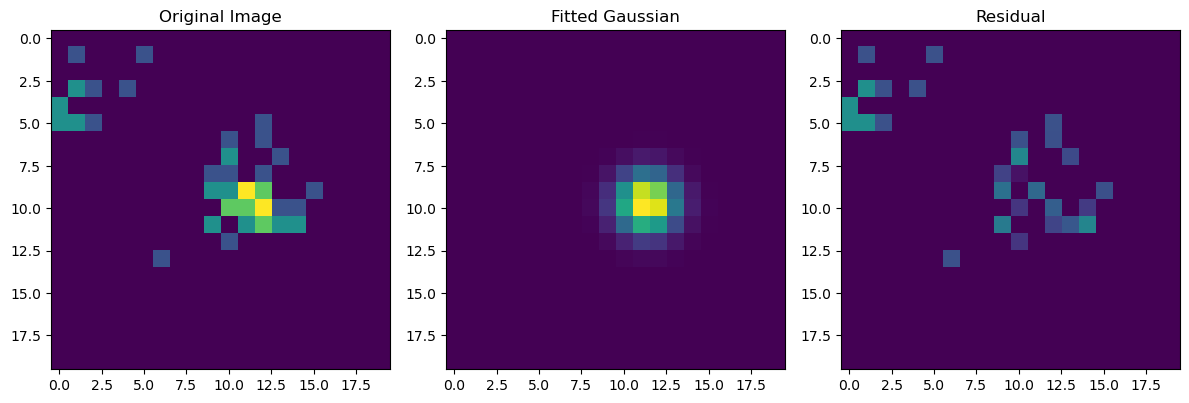

[[Model]]
    Model(gaussian_2d_symmetric)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 61
    # data points      = 400
    # variables        = 4
    chi-square         = 55.4313877
    reduced chi-square = 0.13997825
    Akaike info crit   = -782.527420
    Bayesian info crit = -766.561561
    R-squared          = 0.59744086
[[Variables]]
    amplitude:  4.62142945 +/- 0.25554061 (5.53%) (init = 5)
    xo:         11.3163108 +/- 0.06459504 (0.57%) (init = 10)
    yo:         9.74186344 +/- 0.06459591 (0.66%) (init = 10)
    sigma:      1.16821380 +/- 0.04568061 (3.91%) (init = 1)
    offset:     0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = -0.7071


In [18]:
image_dataframe = image_data[frame_to_fit+1]

x = np.linspace(0, 19, 20)
y = np.linspace(0, 19, 20)
xy = np.meshgrid(x, y)
result = fit_2d_gaussian_symmetric(xy, image_dataframe)

plot_results(image_dataframe, result)